## inference in simple model using synthetic data
population size 10^5

we run several independent computations on different data sets, as a test of whether inferred parameters are reliable

In [1]:
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [2]:
%matplotlib inline
import numpy as np
import os
import pickle
import pprint
import time

import pyross
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from matplotlib import rc; rc('text', usetex=True)

import synth_fns

(cell 3 was removed to hide local file info)
### main settings

In [4]:
## for dataFiles : needs a fresh value in every notebooke
#fileRoot = 'dataSynthInfQuality-pop1e5'  ## this was runID 0

## we can run this notebook several times to gets lots of data...
runID = 0
fileRoot = 'dataSynthInfQuality-pop1e5-run{r:d}'.format(r=runID)

## total population
popN = 1e5

## tau-leaping param, take this negative to force gillespie
## or set a small value for high-accuracy tau-leap (eg 1e-4 or 1e-5)
leapEps = -1

## do we use small tolerances for the likelihood computations? (use False for debug etc)
isHighAccuracy = True

# absolute tolerance for logp for MAP 
inf_atol = 0.1

## prior mean of beta, divided by true value (set to 1.0 for the simplest case)
betaPriorOffset = 1.0
betaPriorLogNorm = False

## mcmc
mcSamples = 5000
nProcMCMC = 2 # None ## take None to use default but large numbers are not efficient in this example

## how many synthetic trajectories
nTraj = 8

### model

In [5]:
model_dict = synth_fns.get_model(popN)

model_spec = model_dict['mod']
contactMatrix = model_dict['CM']
parameters_true = model_dict['params']
cohortsM = model_dict['cohortsM']
Ni = model_dict['cohortsPop']

trajSeed = 18+(nTraj*runID)
infSeed = 21+(nTraj*runID)

#### more settings

In [6]:
## total trajectory time (bare units)
Tf_bare = 20
## total inf time
Tf_inf_bare = 5

## inference period starts when the total deaths reach this amount (as a fraction)
fracDeaths = 2e-3 # int(N*200/1e5)


In [7]:
## hack to get higher-frequency data
## how many data points per "timestep" (in original units)
fineData = 4

## this assumes that all parameters are rates !!
for key in parameters_true:
    #print(key,parameters_true[key])
    parameters_true[key] /= fineData

Tf = Tf_bare * fineData;  
Nf = Tf+1

Tf_inference = Tf_inf_bare * fineData
Nf_inference = Tf_inference+1

### plotting helper functions

In [8]:
def plotTraj(M,data_array,Nf_start,Tf_inference,fineData):
    fig = plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
    #plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=12)
    t = np.linspace(0, Tf/fineData, Nf)

    # plt.plot(t, np.sum(data_array[:, :M], axis=1), '-o', label='S', lw=4)
    plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-o', label='Exposed', lw=2)
    plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-o', label='Infected', lw=2)
    plt.plot(t, np.sum(data_array[:, 3*M:4*M], axis=1), '-o', label='Deaths', lw=2)
    #plt.plot(t, N-np.sum(data_array[:, 0:4*M], axis=1), '-o', label='Rec', lw=2)

    plt.axvspan(Nf_start/fineData, (Nf_start+Tf_inference)/fineData,alpha=0.3, color='dodgerblue')
    plt.legend()
    plt.show()

    fig,axs = plt.subplots(1,2, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
    ax = axs[0]
    ax.plot(t[1:],np.diff(np.sum(data_array[:, 3*M:4*M], axis=1)),'o-',label='death increments', lw=1)
    ax.legend(loc='upper right') ; # plt.show()

    ax = axs[1]
    ax.plot(t,np.sum(data_array[:, 3*M:4*M], axis=1),'o-',label='deaths',ms=3)
    ax.legend() ; 

    plt.show()


def plotMAP(res,data_array,M,N,estimator,Nf_start,Tf_inference,fineData):
    print('**beta(bare units)',res['params_dict']['beta']*fineData)
    print('**logLik',res['log_likelihood'],'true was',logpTrue)
    print('\n')
    print(res)

    fig,axs = plt.subplots(1,3, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.subplots_adjust(wspace=0.3)
    #plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=12)
    t = np.linspace(0, Tf/fineData, Nf)

    ax = axs[0]

    #plt.plot(t, np.sum(data_array[:, :M], axis=1), '-o', label='S', lw=4)
    ax.plot(t, np.sum(data_array[:, M:2*M], axis=1), 'o', label='Exposed', lw=2)
    ax.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), 'o', label='Infected', lw=2)
    ax.plot(t, np.sum(data_array[:, 3*M:4*M], axis=1), 'o', label='Deaths', lw=2)
    #plt.plot(t, N-np.sum(data_array[:, 0:4*M], axis=1), '-o', label='Rec', lw=2)

    tt = np.linspace(Nf_start, Tf, Nf-Nf_start,)/fineData
    xm = estimator.integrate(res['x0'], Nf_start, Tf, Nf-Nf_start, dense_output=False)
    #plt.plot(tt, np.sum(xm[:, :M], axis=1), '-x', label='S-MAP', lw=2, ms=3)
    ax.plot(tt, np.sum(xm[:, M:2*M], axis=1), '-x', color='C0',label='E-MAP', lw=2, ms=3)
    ax.plot(tt, np.sum(xm[:, 2*M:3*M], axis=1), '-x', color='C1',label='I-MAP', lw=2, ms=3)
    ax.plot(tt, np.sum(xm[:, 3*M:4*M], axis=1), '-x', color='C2',label='D-MAP', lw=2, ms=3)
    #plt.plot(tt, N-np.sum(xm[:, :4*M], axis=1), '-o', label='R-MAP', lw=2)

    ax.axvspan(Nf_start/fineData, (Nf_start+Tf_inference)/fineData,alpha=0.3, color='dodgerblue')
    ax.legend()

    ax = axs[1]
    ax.plot(t[1:], np.diff(np.sum(data_array[:, 3*M:4*M], axis=1)), '-o', label='death incs', lw=2)
    ax.plot(tt[1:], np.diff(np.sum(xm[:, 3*M:4*M], axis=1)), '-x', label='MAP', lw=2, ms=3)
    ax.axvspan(Nf_start/fineData, (Nf_start+Tf_inference)/fineData,alpha=0.3, color='dodgerblue')
    ax.legend()

    ax = axs[2]

    ax.plot(t, np.sum(data_array[:, :M], axis=1), '-o', label='Sus', lw=1.5, ms=3)
    #plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-o', label='Exposed', lw=2)
    #plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-o', label='Infected', lw=2)
    #plt.plot(t, np.sum(data_array[:, 3*M:4*M], axis=1), '-o', label='Deaths', lw=2)
    ax.plot(t, N-np.sum(data_array[:, 0:4*M], axis=1), '-o', label='Rec', lw=1.5, ms=3)

    #infResult = res
    tt = np.linspace(Nf_start, Tf, Nf-Nf_start,)/fineData
    xm = estimator.integrate(res['x0'], Nf_start, Tf, Nf-Nf_start, dense_output=False)
    ax.plot(tt, np.sum(xm[:, :M], axis=1), '-x', label='S-MAP', lw=2, ms=3)
    #plt.plot(tt, np.sum(xm[:, M:2*M], axis=1), '-x', label='E-MAP', lw=2, ms=3)
    #plt.plot(tt, np.sum(xm[:, 2*M:3*M], axis=1), '-x', label='I-MAP', lw=2, ms=3)
    #plt.plot(tt, np.sum(xm[:, 3*M:4*M], axis=1), '-x', label='D-MAP', lw=2, ms=3)
    ax.plot(tt, N-np.sum(xm[:, :4*M], axis=1), '-x', label='R-MAP', lw=1.5, ms=3)

    ax.axvspan(Nf_start/fineData, (Nf_start+Tf_inference)/fineData,alpha=0.3, color='dodgerblue')
    ax.legend()
    plt.show()
    

    
def plotMCtrace(selected_dims, sampler, numTrace=None):
    # Plot the trace for these dimensions:
    plot_dim = len(selected_dims)
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(plot_dim, figsize=(12, plot_dim), sharex=True)
    samples = sampler.get_chain()
    if numTrace == None : numTrace = np.shape(samples)[1]  ## corrected index
    for ii,dd in enumerate(selected_dims):
        ax = axes[ii]
        ax.plot(samples[:, :numTrace , dd], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
    axes[-1].set_xlabel("step number");
    plt.show(fig)
    plt.close()

def plotPosteriors(estimator,obsData, fltrDeath, Tf_inference,param_priors, init_priors,contactMatrix,
                   infResult,parameters_true,trueInit,rangeParam=0.5) :
    ## used for prior pdfs
    (likFun,priFun,dimFlat) = pyross.evidence.latent_get_parameters(estimator,
                                        obsData, fltrDeath, Tf_inference,
                                        param_priors, init_priors,                                   
                                        contactMatrix,
                                        #intervention_fun=interventionFn,
                                        tangent=False,
                                      )
    xVals = np.linspace(parameters_true['beta']*(1-rangeParam),parameters_true['beta']*(1+rangeParam),100)

    betas = [ rr['params_dict']['beta'] for rr in result_mcmc ]
    plt.hist(betas,density=True,color='lightblue',label='posterior')
    yVal=2
    plt.plot([infResult['params_dict']['beta']],[yVal],'bs',label='MAP',ms=10)
    plt.plot([parameters_true['beta']],[yVal],'ro',label='true',ms=10)


    ## this is a bit complicated, it just finds the prior for beta from the infResult
    var='beta'
    jj = infResult['param_keys'].index(var)
    xInd = infResult['param_guess_range'][jj]
    #print(jj,xInd)
    pVals = []
    for xx in xVals :
        flatP = np.zeros( dimFlat )
        flatP[xInd] = xx
        pdfAll = np.exp( priFun.logpdf(flatP) )
        pVals.append( pdfAll[xInd] )
    plt.plot(xVals,pVals,color='darkgreen',label='prior')


    plt.xlabel(var)
    plt.ylabel('pdf')
    plt.legend()

    labs=['init S','init E','init I']
    nPanel=3
    fig,axs = plt.subplots(1,nPanel,figsize=(14,4))
    for ii in range(nPanel) :   
        ax = axs[ii]
        yVal=1.0/popN
        xs = [ rr['x0'][ii] for rr in result_mcmc ]
        ax.hist(xs,color='lightblue',density=True)
        ax.plot([infResult['x0'][ii]],yVal,'bs',label='true')
        ax.plot([trueInit[ii]],yVal,'ro',label='true')


        ## this is a bit complicated, it just finds the prior for beta from the infResult
        ## axis ranges
        xMin = np.min(xs)*0.8
        xMax = np.max(xs)*1.2
        xVals = np.linspace(xMin,xMax,100)

        ## this ID is a negative number because the init params are the end of the 'flat' param array
        paramID = ii-nPanel 
        pVals = []
        for xx in xVals :
            flatP = np.zeros( dimFlat )
            flatP[paramID] = xx
            pdfAll = np.exp( priFun.logpdf(flatP) )
            pVals.append( pdfAll[paramID] )
        ax.plot(xVals,pVals,color='darkgreen',label='prior')

        #plt.xlabel(var)
        ax.set_xlabel(labs[ii])
        ax.set_ylabel('pdf')
        ax.yaxis.set_ticklabels([])

    plt.show()


### run

trajSeed 19
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 19}
traj generation time 4.957489252090454 secs
inf starts at timePoint 26
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=22, Mon May  3 22:17:13 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 9.613175904140498e+01 1.0e+00 9.91e-01  1e-02  3e+03 0:04.2
    2    128 9.529302861342319e+01 1.7e+00 9.16e-01  8e-03  3e+03 0:08.1
    3    192 9.460778928893433e+01 2.7e+00 9.07e-01  5e-03  2e+03 0:12.2
    4    256 9.529674330195765e+01 3.9e+00 8.85e-01  4e-03  2e+03 0:16.1
    6    384 9.427442234895523e+01 4.8e+00 8.94e-01  3e-03  1e+03 0:24.0
    8    512 9.433653991887118e+01 6.7e+00 9.56e-01  2e-03  1e+03 0:32.2
   10    640 9.417571408942169e+01 9.9e+00 9.53e-01  1e-03  7e+02 0:40.9
   12    768 9.416932392086663e+01 8.6e+00 7.69e-01  7e-04  3e+02 0:49.6
   14    896 9.416254

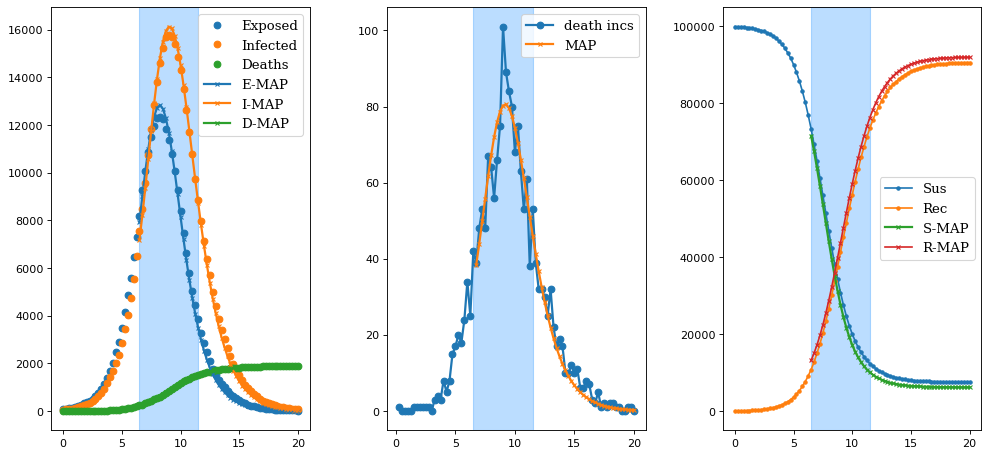

trajSeed 20
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 20}
traj generation time 5.476336479187012 secs
inf starts at timePoint 26
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=23, Mon May  3 22:18:40 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 9.667186861874205e+01 1.0e+00 9.35e-01  1e-02  3e+03 0:04.2
    2    128 9.654161978261240e+01 1.6e+00 8.86e-01  7e-03  2e+03 0:08.4
    3    192 9.614524907044382e+01 2.4e+00 9.14e-01  5e-03  2e+03 0:13.0
    4    256 9.608368007081326e+01 3.5e+00 8.14e-01  3e-03  2e+03 0:17.4
    5    320 9.575826158817264e+01 4.8e+00 6.71e-01  2e-03  1e+03 0:21.9
    7    448 9.568165677256701e+01 6.8e+00 5.73e-01  1e-03  8e+02 0:30.8
    9    576 9.566169298806885e+01 9.4e+00 4.96e-01  9e-04  4e+02 0:39.5
   11    704 9.566058368982067e+01 1.2e+01 4.37e-01  5e-04  2e+02 0:48.0
   13    832 9.566009

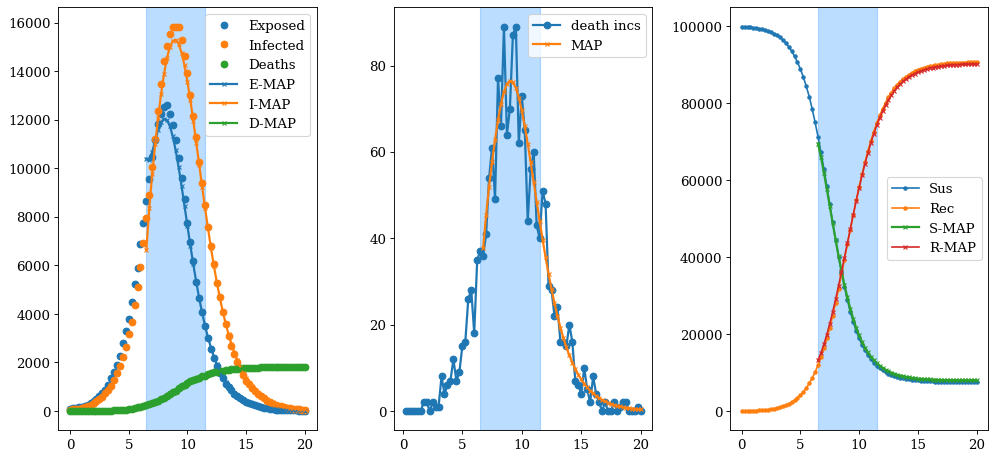

trajSeed 21
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 21}
traj generation time 9.460419654846191 secs
inf starts at timePoint 27
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=24, Mon May  3 22:19:58 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 8.864077735823857e+01 1.0e+00 8.79e-01  1e-02  3e+03 0:06.4
    2    128 8.894237541987508e+01 1.7e+00 7.91e-01  7e-03  2e+03 0:13.3
    3    192 8.808359652995587e+01 2.6e+00 9.17e-01  6e-03  3e+03 0:20.4
    4    256 8.832826636664467e+01 4.1e+00 8.26e-01  4e-03  2e+03 0:27.6
    5    320 8.797178863792085e+01 5.2e+00 7.48e-01  3e-03  2e+03 0:34.4
    6    384 8.781027066064999e+01 6.2e+00 6.61e-01  2e-03  1e+03 0:41.3
    7    448 8.780915861918197e+01 6.9e+00 5.73e-01  1e-03  6e+02 0:47.9
    9    576 8.777666752570860e+01 9.0e+00 5.33e-01  7e-04  4e+02 1:01.7
   11    704 8.777257

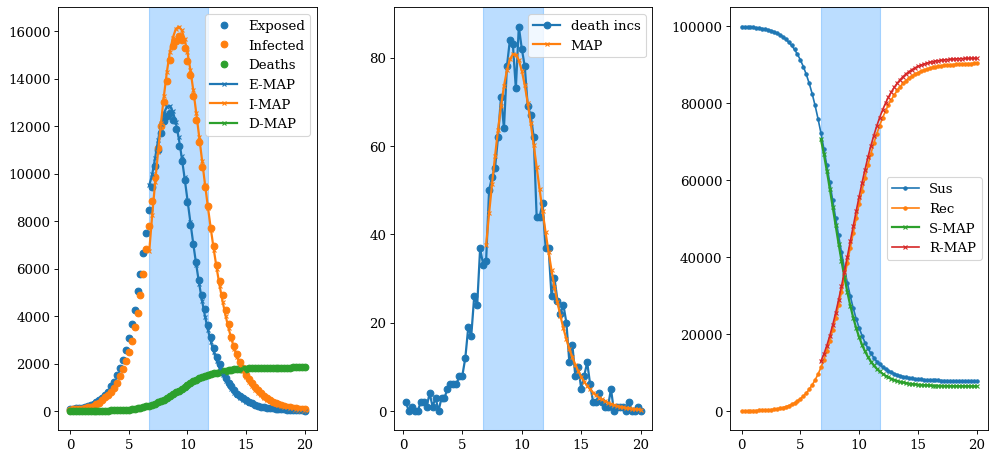

trajSeed 22
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 22}
traj generation time 12.617037296295166 secs
inf starts at timePoint 26
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=25, Mon May  3 22:22:03 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 9.039171164349825e+01 1.0e+00 1.11e+00  1e-02  4e+03 0:06.4
    2    128 8.925237968566275e+01 1.9e+00 1.07e+00  9e-03  3e+03 0:12.5
    3    192 8.915538294371521e+01 2.6e+00 9.87e-01  6e-03  2e+03 0:16.9
    4    256 8.937214678697907e+01 3.7e+00 8.48e-01  5e-03  2e+03 0:21.2
    5    320 8.880932327424544e+01 5.0e+00 8.36e-01  3e-03  2e+03 0:25.5
    7    448 8.870721440713231e+01 5.7e+00 8.54e-01  3e-03  1e+03 0:34.5
    9    576 8.864565047952229e+01 7.7e+00 7.63e-01  1e-03  8e+02 0:43.4
   11    704 8.861730379218676e+01 8.7e+00 6.80e-01  6e-04  4e+02 0:52.5
   13    832 8.86167

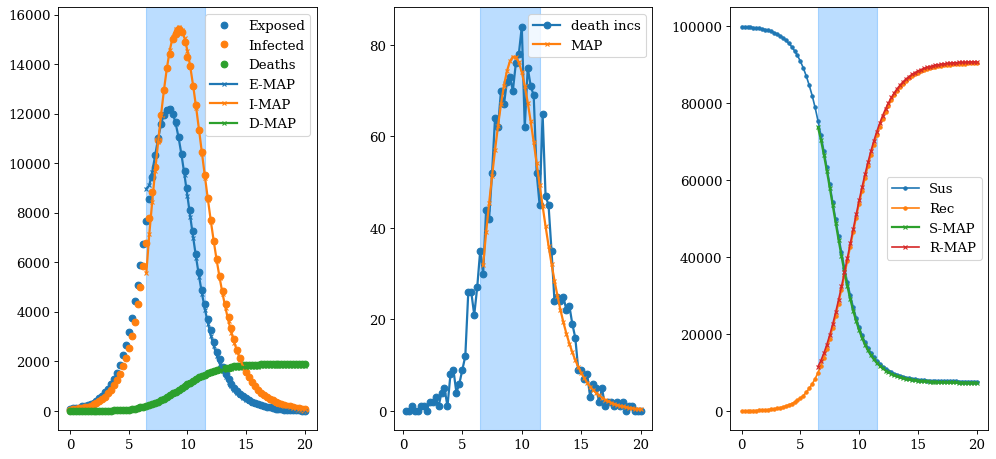

trajSeed 23
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 23}
traj generation time 6.165742874145508 secs
inf starts at timePoint 26
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=26, Mon May  3 22:23:26 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 9.326813397994216e+01 1.0e+00 1.00e+00  1e-02  3e+03 0:04.4
    2    128 9.296592636073869e+01 1.8e+00 1.12e+00  9e-03  4e+03 0:08.7
    3    192 9.325050662962946e+01 3.4e+00 9.52e-01  5e-03  3e+03 0:13.2
    4    256 9.208995949690954e+01 4.9e+00 9.75e-01  4e-03  2e+03 0:17.5
    5    320 9.221677167627057e+01 5.1e+00 8.80e-01  3e-03  2e+03 0:21.9
    7    448 9.205238931489316e+01 7.9e+00 7.70e-01  2e-03  1e+03 0:30.4
    9    576 9.200892602327032e+01 8.5e+00 6.12e-01  8e-04  4e+02 0:39.1
   11    704 9.199145527093148e+01 8.6e+00 5.27e-01  4e-04  2e+02 0:48.0
   13    832 9.198946

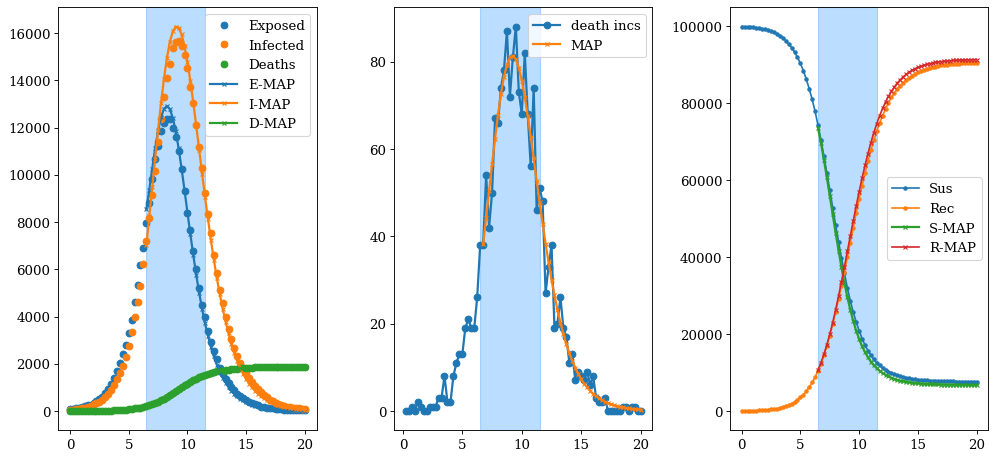

trajSeed 24
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 24}
traj generation time 13.570582151412964 secs
inf starts at timePoint 27
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=27, Mon May  3 22:25:02 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 9.598076089713577e+01 1.0e+00 9.42e-01  1e-02  3e+03 0:06.7
    2    128 9.470182036518921e+01 1.6e+00 9.49e-01  9e-03  3e+03 0:13.2
    3    192 9.462518070376369e+01 2.6e+00 9.07e-01  6e-03  3e+03 0:20.1
    4    256 9.368347812135670e+01 3.9e+00 7.95e-01  4e-03  2e+03 0:27.1
    5    320 9.333084513512497e+01 5.2e+00 7.44e-01  3e-03  1e+03 0:34.0
    6    384 9.320713051508088e+01 5.9e+00 6.59e-01  2e-03  1e+03 0:41.0
    7    448 9.322511600593697e+01 7.1e+00 5.60e-01  1e-03  7e+02 0:47.7
    9    576 9.320245726345762e+01 7.6e+00 5.74e-01  8e-04  4e+02 1:01.2
   11    704 9.31952

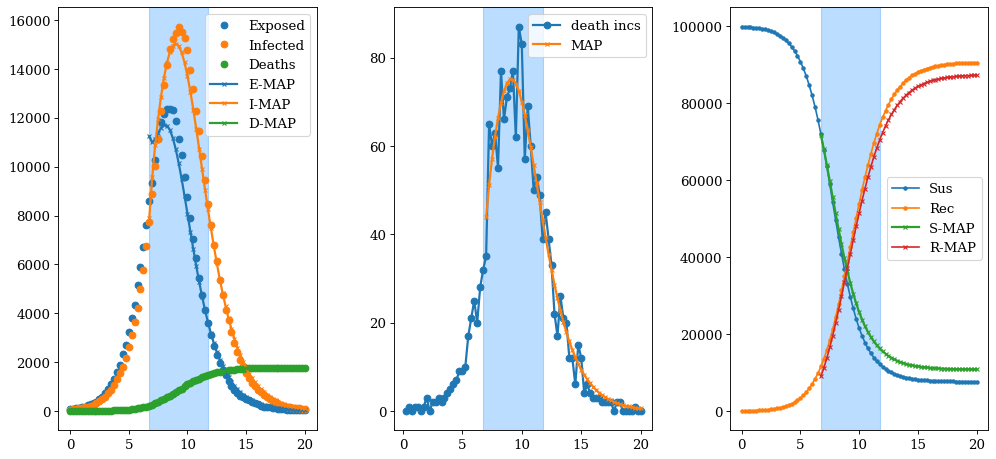

trajSeed 25
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 25}
traj generation time 5.7076311111450195 secs
inf starts at timePoint 25
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=28, Mon May  3 22:26:55 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 9.043798543920198e+01 1.0e+00 9.31e-01  1e-02  3e+03 0:04.4
    2    128 9.098084698966127e+01 1.6e+00 9.61e-01  8e-03  3e+03 0:08.9
    3    192 9.039984312301590e+01 2.7e+00 9.04e-01  5e-03  2e+03 0:13.1
    4    256 9.017795298881319e+01 4.0e+00 8.10e-01  4e-03  2e+03 0:17.6
    5    320 9.014561482334518e+01 5.3e+00 7.65e-01  3e-03  1e+03 0:22.1
    7    448 8.996144761517348e+01 6.4e+00 6.88e-01  2e-03  8e+02 0:31.0
    9    576 8.995217352178790e+01 7.9e+00 5.38e-01  8e-04  4e+02 0:39.6
   11    704 8.994796040307151e+01 7.9e+00 4.89e-01  4e-04  2e+02 0:48.2
   13    832 8.99475

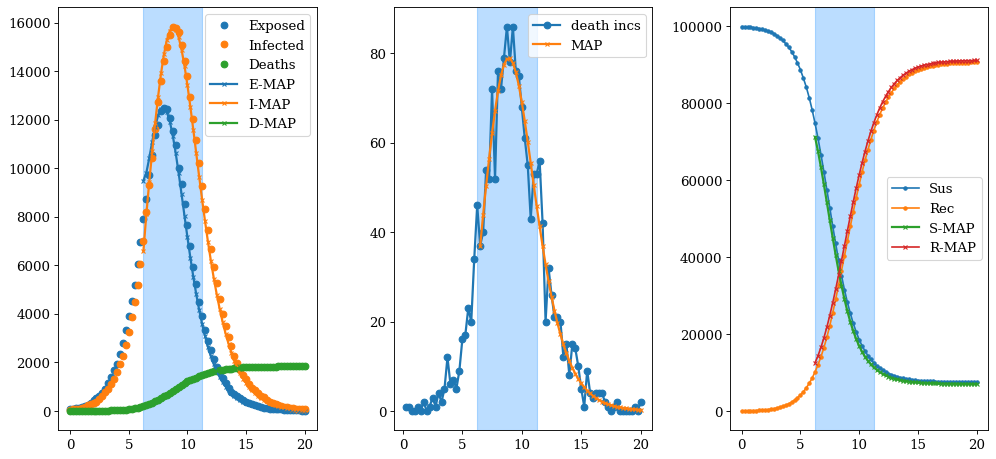

trajSeed 26
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 26}
traj generation time 7.664235353469849 secs
inf starts at timePoint 26
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=29, Mon May  3 22:28:16 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 9.528594920939574e+01 1.0e+00 8.94e-01  1e-02  3e+03 0:04.6
    2    128 9.573480787125793e+01 1.7e+00 8.88e-01  7e-03  3e+03 0:09.0
    3    192 9.504457922190217e+01 2.6e+00 9.80e-01  5e-03  3e+03 0:13.4
    4    256 9.542642682517071e+01 4.9e+00 9.06e-01  4e-03  2e+03 0:17.6
    5    320 9.497933974663071e+01 6.0e+00 8.82e-01  3e-03  2e+03 0:22.1
    7    448 9.476518033417695e+01 7.7e+00 7.33e-01  2e-03  9e+02 0:31.9
    8    512 9.475315385087578e+01 7.7e+00 6.27e-01  1e-03  5e+02 0:38.8
   10    640 9.474368144788411e+01 8.6e+00 5.29e-01  5e-04  3e+02 0:52.5
   12    768 9.474381

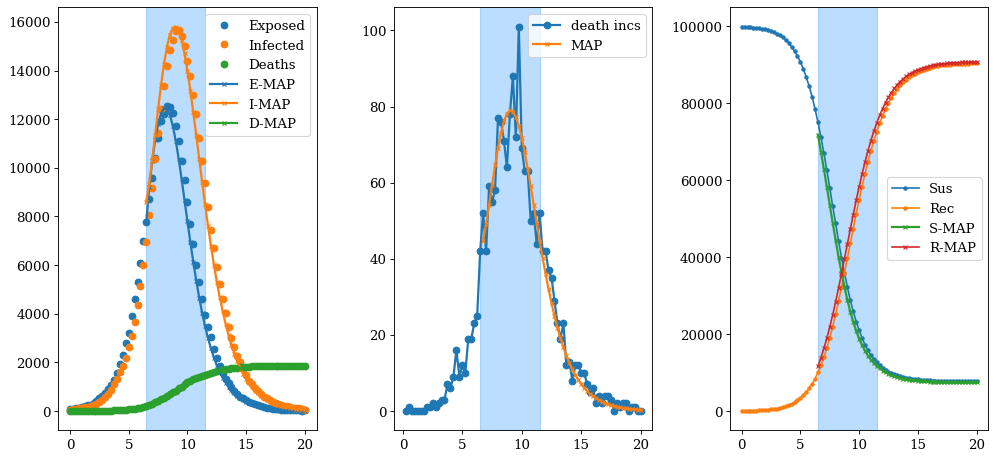

In [9]:
allData = []
allResultsInf = []

for trajIndex in range(nTraj) :
    
    trajSeed += 1
    infSeed += 1
    #mcSeed += 1
    print('trajSeed',trajSeed)
    
    ticTime = time.time()
    syntheticData = synth_fns.make_stochastic_traj(Tf,Nf,trajSeed,model_dict,leapEps)
    tocTime = time.time() - ticTime
    print('traj generation time',tocTime,'secs')

    np.save(fileRoot+'-stochTraj{s:d}.npy'.format(s=trajSeed),syntheticData)

    Nf_start = synth_fns.get_start_time(syntheticData, popN, fracDeaths)
    print('inf starts at timePoint',Nf_start)

    #plotTraj(cohortsM,syntheticData,Nf_start,Tf_inference,fineData)


    [estimator,fltrDeath,obsData,trueInit] = synth_fns.get_estimator(isHighAccuracy,model_dict,syntheticData, popN, Nf_start, Nf_inference,)

    allData += [obsData]
    
    ## compute log-likelihood of true params
    logpTrue = -estimator.minus_logp_red(parameters_true, trueInit, obsData, fltrDeath, Tf_inference, 
                                         contactMatrix, tangent=False)
    #print('**logLikTrue',logpTrue,'\n')

    #print('death data\n',obsData,'length',np.size(obsData),Nf_inference)

    [param_priors,init_priors] = synth_fns.get_priors(model_dict,betaPriorOffset,betaPriorLogNorm,fracDeaths,estimator)
    #print('Prior Params:',param_priors)
    #print('Prior Inits:')
    #pprint.pprint(init_priors)
    #print('trueBeta',parameters_true['beta'])
    #print('trueInit',trueInit)

    infResult = synth_fns.do_inf(estimator, obsData, fltrDeath, syntheticData, 
                                 popN, Tf_inference, infSeed, param_priors,init_priors, model_dict, inf_atol)

    allResultsInf += [infResult]
    
    #pprint.pprint(infResult)
    #print('MAP likelihood',infResult['log_likelihood'],'true',logpTrue)
    #print('MAP beta',infResult['params_dict']['beta'],'true',parameters_true['beta'])

    plotMAP(infResult,syntheticData,cohortsM,popN,estimator,Nf_start,Tf_inference,fineData)



In [10]:
mapBetas = np.array( [ rr['params_dict']['beta'] for rr in allResultsInf ] )
print(np.mean(mapBetas))
print(np.std(mapBetas))
print(mapBetas)

0.03534030774521899
0.0024093485443312545
[0.03812795 0.03453195 0.03730055 0.03563109 0.03624306 0.02962314
 0.03608876 0.03517596]


In [11]:
#assert False

traj 0 of 8
est map [3.81279460e-02 7.15094946e+04 7.91919856e+03 7.18432737e+03] 4


100%|██████████| 5000/5000 [1:55:53<00:00,  1.39s/it]


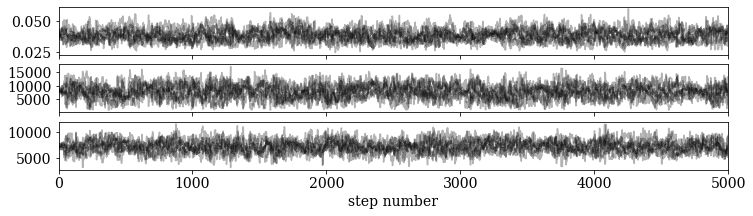

traj 1 of 8
est map [3.45319531e-02 6.94948365e+04 1.04006270e+04 6.64909575e+03] 4


100%|██████████| 5000/5000 [1:14:57<00:00,  1.11it/s]


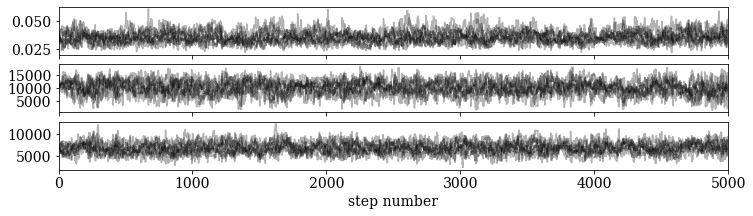

traj 2 of 8
est map [3.73005537e-02 7.05614456e+04 9.50933094e+03 6.74439069e+03] 4


100%|██████████| 5000/5000 [1:04:34<00:00,  1.29it/s]


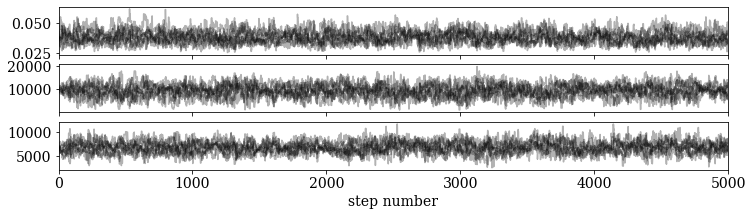

traj 3 of 8
est map [3.56310933e-02 7.36990752e+04 8.96995083e+03 5.58436819e+03] 4


100%|██████████| 5000/5000 [1:04:07<00:00,  1.30it/s]


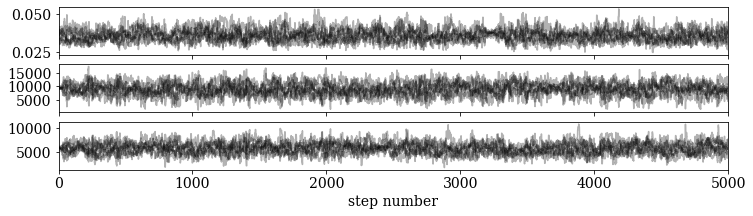

traj 4 of 8
est map [3.62430574e-02 7.35666180e+04 8.54304082e+03 7.01651641e+03] 4


100%|██████████| 5000/5000 [1:04:00<00:00,  1.30it/s]


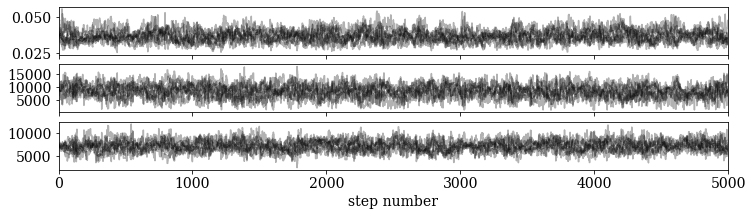

traj 5 of 8
est map [2.96231369e-02 7.15809083e+04 1.12376221e+04 7.88783210e+03] 4


100%|██████████| 5000/5000 [1:03:26<00:00,  1.31it/s]


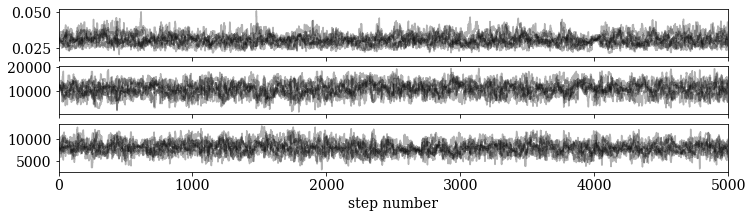

traj 6 of 8
est map [3.60887650e-02 7.11450067e+04 9.49512768e+03 6.58539520e+03] 4


100%|██████████| 5000/5000 [1:04:02<00:00,  1.30it/s]


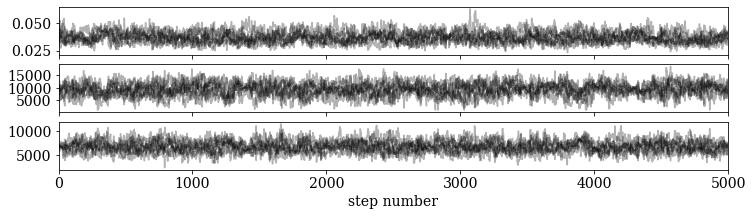

traj 7 of 8
est map [3.51759565e-02 7.17259473e+04 7.81211272e+03 8.60154561e+03] 4


100%|██████████| 5000/5000 [1:03:50<00:00,  1.31it/s]


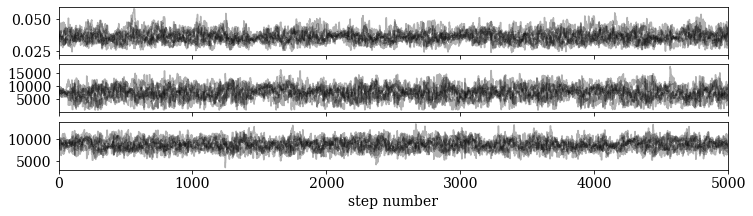

In [12]:
allResultsMC = []
for trajIndex,infResult in enumerate(allResultsInf) :
    print('traj',trajIndex,'of',len(allResultsInf))
    
    obsData = allData[ trajIndex ]
    
    sampler = synth_fns.do_mcmc(mcSamples, nProcMCMC, estimator, Tf_inference, infResult, 
                                obsData, fltrDeath, param_priors, init_priors, 
                                model_dict)
    plotMCtrace([0,2,3], sampler)
    result_mcmc = synth_fns.load_mcmc_result(estimator, obsData, fltrDeath, sampler, param_priors, init_priors, model_dict)
    allResultsMC += [result_mcmc]

### save MCMC data


In [13]:
opFile = fileRoot + "-mcmcAll.pik"
print('opf',opFile)
with open(opFile, 'wb') as f: 
    pickle.dump([allResultsInf,allResultsMC],f)

opf dataSynthInfQuality-pop1e5-run0-mcmcAll.pik


In [14]:
for trajIndex,result_mcmc in enumerate(allResultsMC) :
    betas = [ rr['params_dict']['beta'] for rr in result_mcmc ]
    postMeanBeta = np.mean(betas)
    postStdBeta = np.std(betas)
    postCIBeta = [ np.percentile(betas,2.5) , np.percentile(betas,97.5)]

    #print("beta: true {b:.4f} MAP {m:.4f}".format(b=parameters_true['beta'],m=infResult['params_dict']['beta']))
    print("post: mean {m:.4f} std {s:.4f} CI95 {l:.4f} {u:.4f}".format(m=postMeanBeta,
                                                                     s=postStdBeta,
                                                                     l=postCIBeta[0],u=postCIBeta[1]))



post: mean 0.0389 std 0.0046 CI95 0.0305 0.0481
post: mean 0.0357 std 0.0048 CI95 0.0277 0.0466
post: mean 0.0382 std 0.0049 CI95 0.0304 0.0482
post: mean 0.0358 std 0.0036 CI95 0.0294 0.0433
post: mean 0.0370 std 0.0040 CI95 0.0301 0.0451
post: mean 0.0305 std 0.0035 CI95 0.0243 0.0376
post: mean 0.0368 std 0.0046 CI95 0.0290 0.0463
post: mean 0.0362 std 0.0040 CI95 0.0289 0.0449
